# Data Science Bowl: Candidate Point Generation

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import dicom
import scipy.misc
import matplotlib.pyplot as plt
import skimage

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi

%matplotlib inline
warnings.filterwarnings("ignore")

## Config & Environment

In [2]:
INPUT_FOLDER = 'samples/'  # "samples/" or "stage1/"

patients = os.listdir(INPUT_FOLDER)
patients.sort()

## Utils

In [3]:
def read_ct_scan(folder_name):
    # Read the slices from the dicom file
    slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]

    # Sort the dicom slices in their respective order
    slices.sort(key=lambda x: int(x.InstanceNumber))

    # Get the pixel values for all the slices
    slices = np.stack([s.pixel_array for s in slices])
    slices[slices == -2000] = 0
    return slices


def get_batches(patients):
    for ix, patient in enumerate(patients):
        scan = read_ct_scan(INPUT_FOLDER + patient + '/')
        if ix % 50 == 0:
            print("Processed patient {0} of {1}".format(ix, len(patients)))
        yield scan
        

def save_array(path, arr):
    np.save(path, arr)
    

def load_array(path):
    return np.load(path)


def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 
        
        
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

## Preprocessing

In [4]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    

def normalize(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image[image>1] = 1.
    image[image<0] = 0.
    return image


def zero_center(image):
    image = image - np.mean(image)
    return image

## Lung Segmentation

In [5]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im


def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

## Thresholding & Denoising

After filtering, there's still noise because of blood vessels, so remove the two largest connected components.

In [6]:
def denoise(segmented_ct_scan):
    
    selem = ball(2)
    binary = binary_closing(segmented_ct_scan, selem)

    label_scan = label(binary)

    areas = [r.area for r in regionprops(label_scan)]
    areas.sort()

    for r in regionprops(label_scan):
        max_x, max_y, max_z = 0, 0, 0
        min_x, min_y, min_z = 1000, 1000, 1000

        for c in r.coords:
            max_z = max(c[0], max_z)
            max_y = max(c[1], max_y)
            max_x = max(c[2], max_x)

            min_z = min(c[0], min_z)
            min_y = min(c[1], min_y)
            min_x = min(c[2], min_x)
            
        if len(areas) < 3:
            index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))
            
        elif (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
            for c in r.coords:
                segmented_ct_scan[c[0], c[1], c[2]] = 0
        else:
            index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))
        
        return segmented_ct_scan

## Run Pipeline

In [7]:
gen = get_batches(patients)

for patient in patients:
    scan = next(gen)
    segmented = segment_lung_from_ct_scan(scan)
    segmented[segmented < 604] = 0
    denoised = denoise(segmented)
    normalized = normalize(denoised)
    centered = zero_center(normalized)
    save_array("prepd_{0}{1}.npy".format(INPUT_FOLDER, patient), centered)

Processed patient 0 of 20


##  Pipeline Visualization

Processed patient 0 of 20


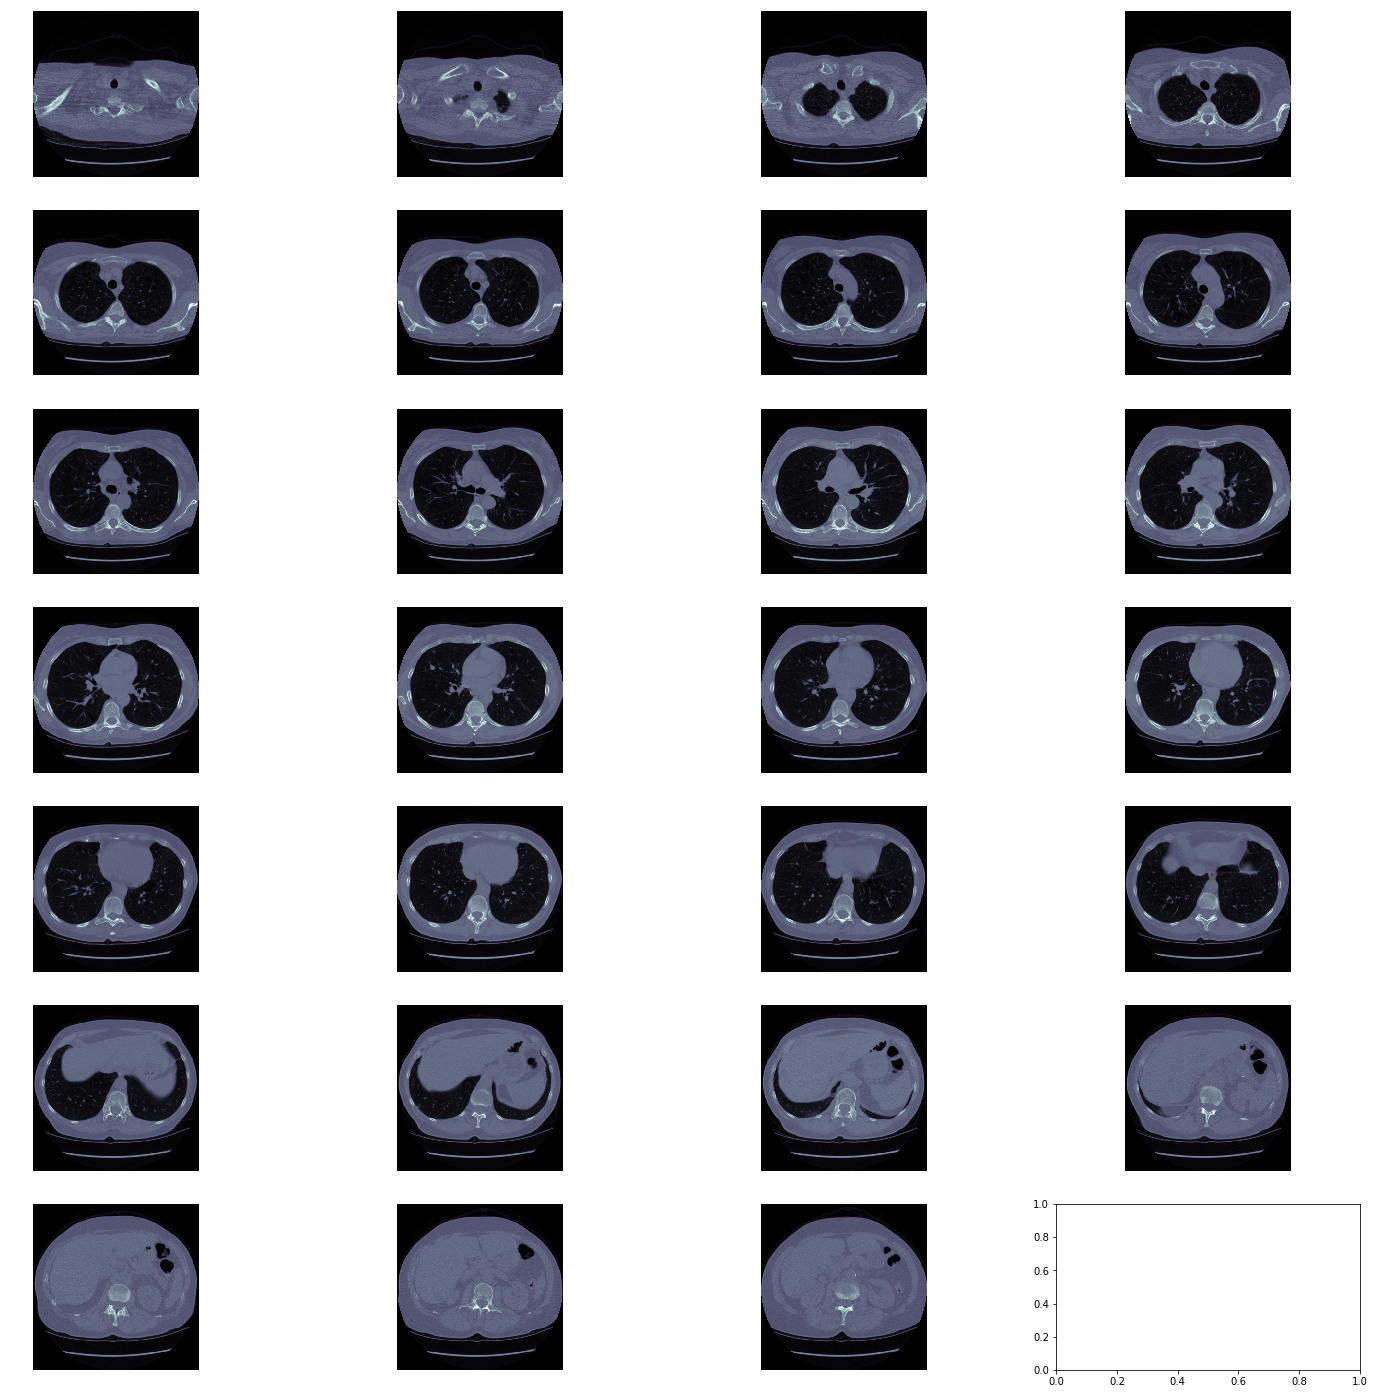

In [8]:
demo_gen = get_batches(patients)  # reset generator
im_index = 100                    # choose a random slice from near the middle of the scan for individual examples

scan = next(demo_gen)

plot_ct_scan(scan)

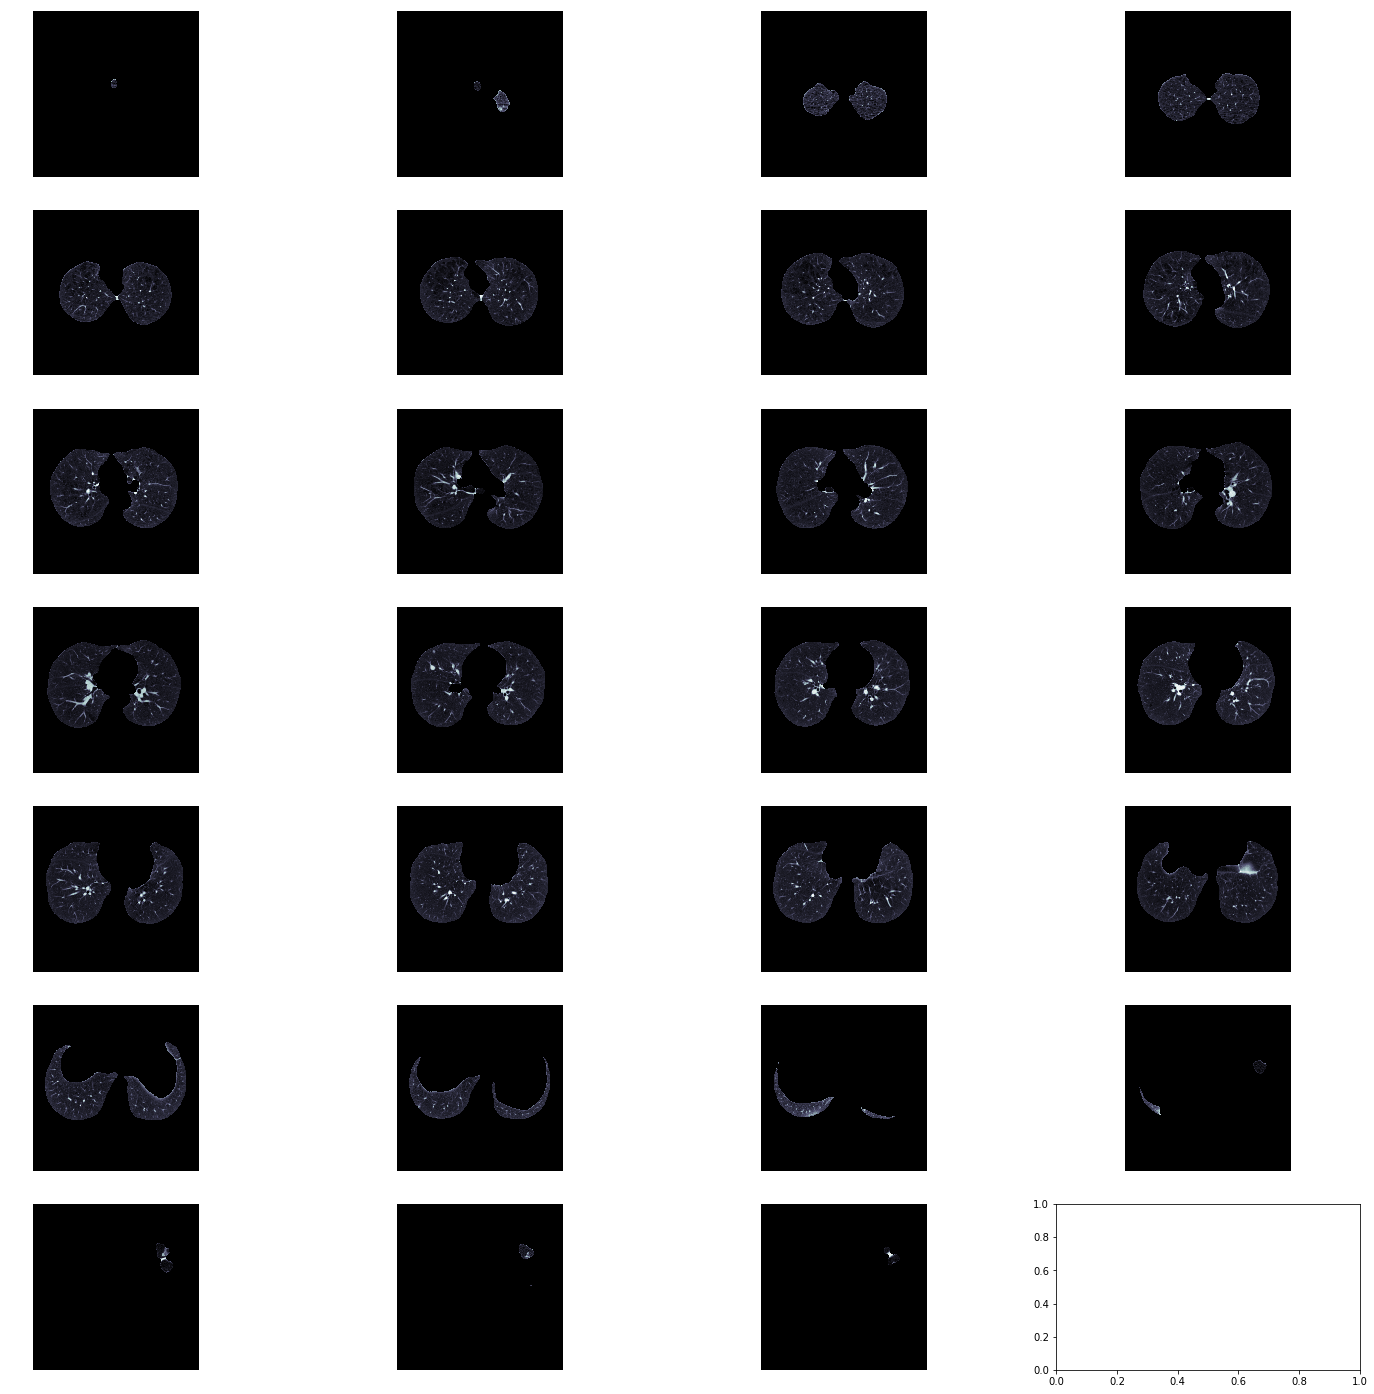

In [9]:
segmented = segment_lung_from_ct_scan(scan)

plot_ct_scan(segmented)

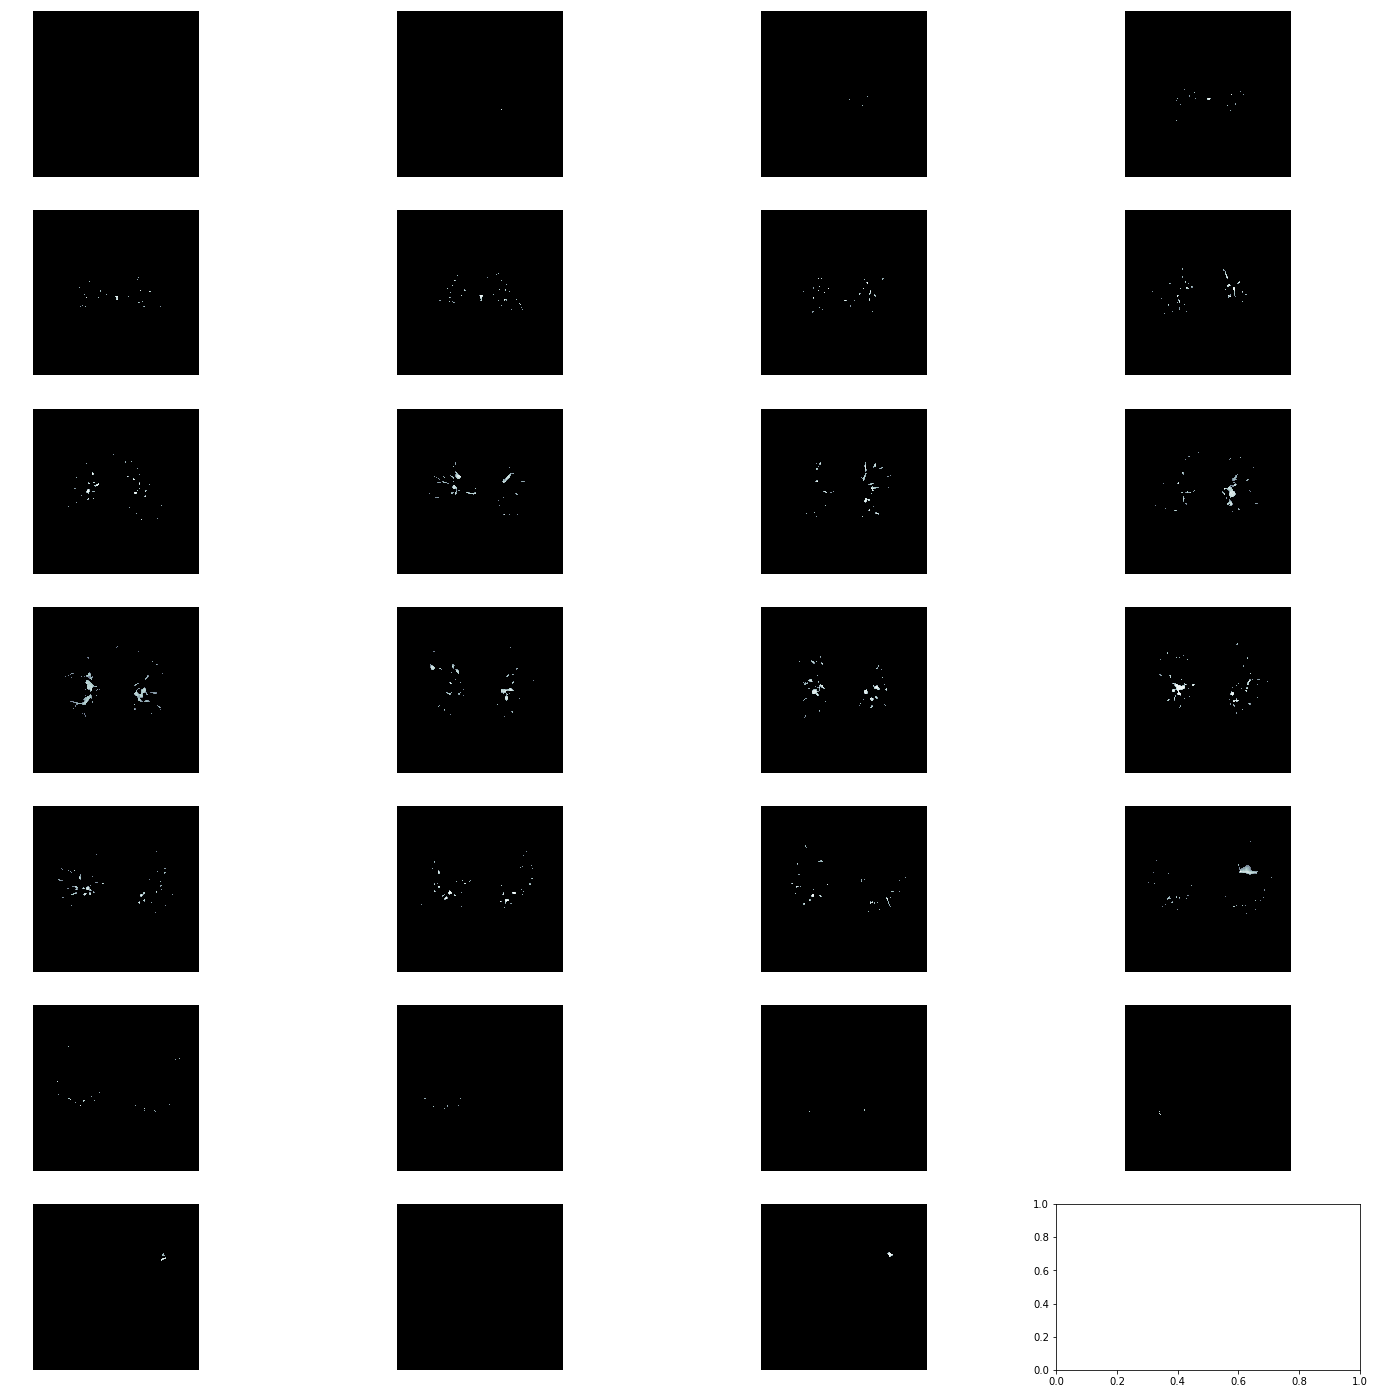

In [10]:
segmented[segmented < 604] = 0
denoised = denoise(segmented)

plot_ct_scan(denoised)

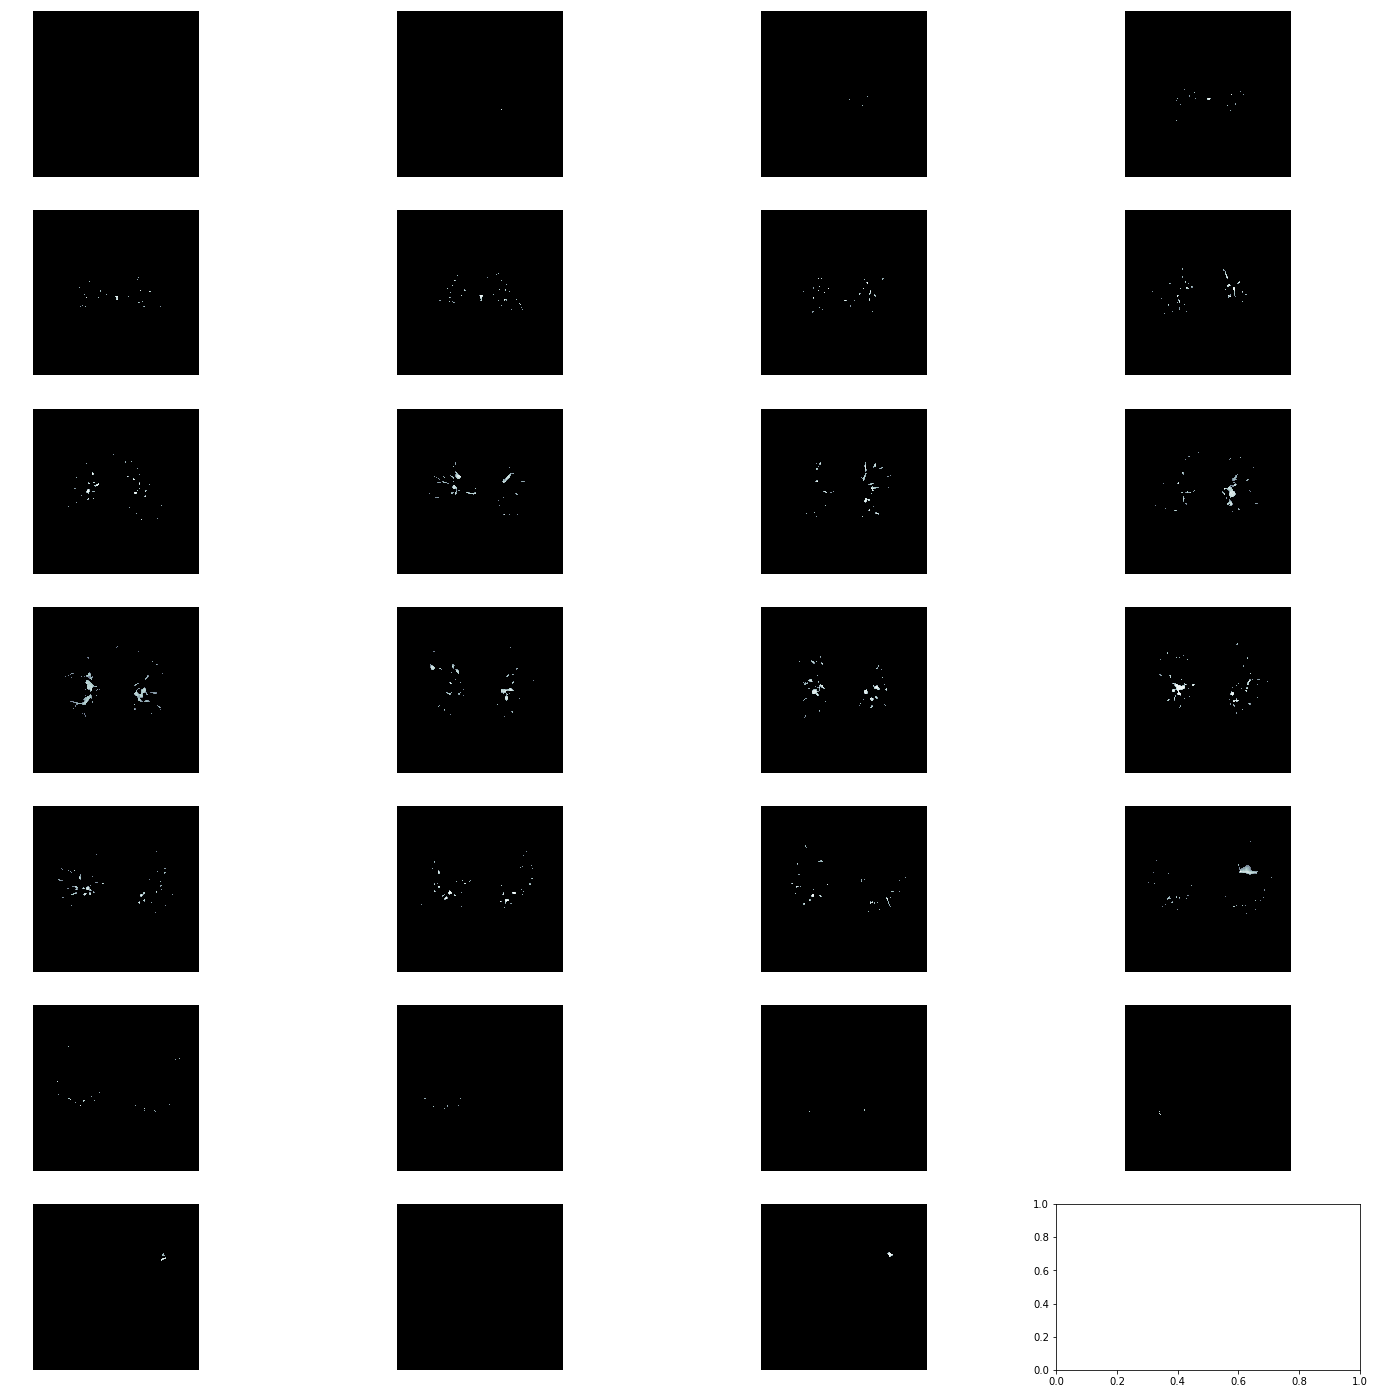

In [11]:
normalized = normalize(denoised)
centered = zero_center(normalized)

plot_ct_scan(centered)

In [12]:
print("Max pixel value:", np.max(centered))
print("Min pixel value:", np.min(centered))
print("Mean pixel value:", np.mean(centered))
print("Std. dev of pixel values:", np.std(centered))
print("\nImage dims:")


print("\n".join([str(slc.shape) for slc in centered]))

Max pixel value: 0.998260340731
Min pixel value: -0.00173965926878
Mean pixel value: 3.15648471291e-17
Std. dev of pixel values: 0.0336148151393

Image dims:
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 